# Разведочный анализ датасета изображений овощей и фруктов

**Цели ноутбука:**   
* Провести анализ характеристик изображений
* Провести анализ метаданных изображений
* Провести визуальный анализ изображений
* Визуализировать данные
* Провести первичную предобработку
* Сделать выводы по структуре данных

Для разведочного анализа используется подготовленный датасет, состоящий из изображений овощей и фруктов

In [ ]:
# Для работы с EXIF-данными картинок
!pip install exif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 4.7 MB/s eta 0:00:00


In [ ]:
import zipfile
import os
import shutil
import random
import hashlib

import gdown

from tqdm.auto import tqdm

from PIL import Image, ExifTags, ImageOps, ImageChops, ImageEnhance
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import pandas as pd

# Для работы с EXIF-данными картинок
import exif

In [ ]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    DRIVE_DIR = os.path.join("/content/drive", "MyDrive")
except ImportError:
    DRIVE_DIR = os.getcwd()

DATASET_DIR = os.path.join(os.getcwd(), "dataset")
ZIP_PATH = os.path.join(DRIVE_DIR, "final_dataset.zip")
os.makedirs(DATASET_DIR, exist_ok=True)

Mounted at /content/drive


In [ ]:
file_id = "1EbvcZbzVXSmB2N1SZYNeUfUuXb8wp3-k"
if os.path.exists(ZIP_PATH):
    print("Архив уже добавлен")
else:
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        os.path.join(os.getcwd(), "final_dataset.zip"),
        quiet=False,
    )

Архив уже добавлен


In [ ]:
# Распаковка архива
with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall("./dataset")

# Проверим структуру папок
print(f"Количество папок: {len(os.listdir(DATASET_DIR))}")

Количество папок: 33


In [ ]:
# Список классов
classes = os.listdir(DATASET_DIR)
class_counts = {cl: len(os.listdir(os.path.join(DATASET_DIR, cl))) for cl in classes}

print(f"Классы: {', '.join(classes)}")

Классы: Cucumber, Kiwi, Potato, Cauliflower, Avocado, Mango, Papaya, Watermelon, Cabbage, Stawberries, Bitter_Gourd, Plum, Pinenapple, Pear, Bottle_Gourd, Capsicum, Strawberry, Orange, Bean, Peach, Carrot, Radish, Broccoli, Cherry, Tomato, Grape, Brinjal, Onion, Nut, Banana, Apple, Pumpkin, Pepper


## 1. Анализ характеристик изображений

### Средние, минимальные и максимальные размеры изображений

Нахождение среднего, минимального и максимального размера изображений поможет определить оптимальный размер для последующей обработки. Получим размеры изображений и рассчитаем средние, минимальные и максимальные размеры.

In [ ]:
# Функция для возврата списка строк вида [класс, имя файла, ширина, высота]
def check_image_sizes(folder_path, cl):
    sizes = []
    for img in os.listdir(folder_path):
        image = Image.open(os.path.join(folder_path, img))
        sizes.append([cl, img, *image.size])
    return sizes

In [ ]:
# Соберу строки с инофрмацией о размерах, пройдясь по папкам классов
row_list = []
for cl in tqdm(classes):
    folder_path = os.path.join(DATASET_DIR, cl)
    row_list.extend(check_image_sizes(folder_path, cl))

print("Строки имеют вид:")
print(row_list[0])

  0%|          | 0/33 [00:00<?, ?it/s]

Строки имеют вид:
['Cucumber', '115_245_100.jpg', 100, 100]


In [ ]:
df = pd.DataFrame(row_list, columns=["class", "name", "width", "height"])
df.describe()

,width,height
count,46200.000000,46200.000000
mean,180.026515,170.649654
std,68.566513,60.275514
min,100.000000,100.000000
25%,100.000000,100.000000
50%,224.000000,194.000000
75%,224.000000,224.000000
max,453.000000,363.000000


**Среднее значение ширины - 180px, высоты - 171px**  
**Минимальные размеры для ширины и высоты - 100px**. Значительная часть (около 25% датасета) представлена в таком размере.  
**Максимальное значение для ширины - 453px, высоты - 363px**.

Половина изображений имеют ширину до 224px и высоту до 194px, а три четверти изображений имеют размер по ширине и высоте до 224px.

Большая часть изображений из представленных имеют размеры *100x100px* и *224x224px*.
При изменении размера изображений к 224x224px большинство изображений не потеряет деталей, также **данный размер используется в нейронных сетях ResNet, VGG**.  
При приведении датасета к данному размеру многие изображения не придется изменять. Крупных изображений немного, их можно уменьшить без сильной потери информациии.

**Решено использовать размер для изображений 224*224px**

### Средние значения и отклонения по каналам (R, G, B)

Средние значения по каналам могут быть использованы для нормализации изображений, что улучшает обучение моделей.  
Вычислим среднее и стандартное отклонение по каждому из трех каналов (красный, зеленый, синий) для всех изображений.

In [ ]:
# Функция для возврата списка строк вида [класс, имя файла, среднее отклонение rgb, стандартное отклонение rgb]
def check_image_color(folder_path, cl):
    colors = []
    for img in os.listdir(folder_path):
        image = Image.open(os.path.join(folder_path, img))
        img_rgb = image.convert("RGB")
        np_img = np.array(img_rgb)
        np_img = np.array(img_rgb)

        r = np_img[:, :, 0].flatten()
        g = np_img[:, :, 1].flatten()
        b = np_img[:, :, 2].flatten()
        r_mean, g_mean, b_mean = np.mean(r), np.mean(g), np.mean(b)
        r_std, g_std, b_std = np.std(r), np.std(g), np.std(b)
        colors.append([cl, img, r_mean, g_mean, b_mean, r_std, g_std, b_std])
    return colors

In [ ]:
# Соберу строки с инофрмацией о RGB, пройдясь по папкам классов
row_list = []
for cl in tqdm(classes):
    folder_path = os.path.join(DATASET_DIR, cl)
    row_list.extend(check_image_color(folder_path, cl))

print("Строки имеют вид:")
print(row_list[0])

  0%|          | 0/33 [00:00<?, ?it/s]

Строки имеют вид:
['Cucumber', '115_245_100.jpg', 184.1576, 168.6783, 162.9901, 87.62364841890573, 106.42508355228104, 113.13501315680305]


In [ ]:
rgb_df = pd.DataFrame(
    row_list, columns=["class", "name", "mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B"]
)
rgb_df.describe()

,mean_R,mean_G,mean_B,std_R,std_G,std_B
count,46200.000000,46200.000000,46200.000000,46200.000000,46200.000000,46200.000000
mean,147.139797,133.219697,107.733301,60.663980,67.551967,72.078383
std,41.821509,37.045295,42.230280,17.955815,21.060814,25.576460
min,26.282186,12.214096,1.955582,1.499134,1.070150,6.141883
25%,112.218192,108.868558,75.669341,48.815330,51.951530,48.152582
50%,144.601234,127.913026,103.500040,58.583413,63.276547,75.252568
75%,178.763225,157.186029,137.479225,72.230954,84.423801,94.009158
max,254.280698,254.569020,252.173661,120.501555,123.460350,124.705833


In [ ]:
channels = ["Red", "Green", "Blue"]
for cls in rgb_df["class"].unique():
    rows = rgb_df[rgb_df["class"] == cls].values
    mean_r = np.mean(rows[:, 2])
    mean_g = np.mean(rows[:, 3])
    mean_b = np.mean(rows[:, 4])
    std_r = np.std(rows[:, 5])
    std_g = np.std(rows[:, 6])
    std_b = np.std(rows[:, 7])
    means = [mean_r, mean_g, mean_b]
    stds = [std_r, std_g, std_b]
    # Построим бар-график для среднего значения и стандартного отклонения
    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x=channels,
            y=[mean_r, mean_g, mean_b],
            error_y={"type": "data", "array": [std_r, std_g, std_b], "visible": True},
            marker={"color": ["red", "green", "blue"]},
            opacity=0.7,
        )
    )
    fig.update_layout(
        title=f"Среднее значение и стандартное отклонение по каналам (R, G, B) {cls}",
        xaxis_title="Каналы",
        yaxis_title="Значение пикселей",
        width=900,
        height=500,
    )
    fig.show()

Заметно, что среднее значение и стандартное отклонение сильно варьируется от класса к классу. В некоторых классах имеются похожие изображения (изображения одного и того же объекта под разными углами, к примеру), это сказывается на стандартном отклонении.

## 2. Анализ метаданных изображений

У изображений могут быть метаданные. Стоит проверить EXIF в файлах, если у файлов будут найдены метаданные их можно будет использовать как дополнительные признаки

In [ ]:
# Вернет строки вида [класс, имя файла, модель фотоаппарата, значение диафрагмы, значение яркости, фокусное расстояние, коэф. цифрового масштабирования]
def check_exif_data(folder_path, cl):
    exif_rows = []
    for img in os.listdir(folder_path):
        try:
            image = exif.Image(os.path.join(folder_path, img))
            if image.has_exif:
                # Добавляю модель фотоаппарата,
                exif_rows.append(
                    [
                        cl,
                        img,
                        image.get("model"),
                        image.get("aperture_value"),
                        image.get("brightness_value"),
                        image.get("focal_length"),
                        image.get("digital_zoom_ratio"),
                    ]
                )
            else:
                exif_rows.append([cl, img, None, None, None, None, None])
        except:
            print("Не удалось прочитать EXIF")
            exif_rows.append([cl, img, None, None, None, None, None])
    return exif_rows

In [ ]:
# Соберу строки с инофрмацией о EXIF, пройдясь по папкам классов
exif_rows = []
for cl in tqdm(classes):
    folder_path = os.path.join(DATASET_DIR, cl)
    exif_rows.extend(check_exif_data(folder_path, cl))

  0%|          | 0/33 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/exif/_app1_metadata.py:476: RuntimeWarning:

skipping bad IFD 1



Не удалось прочитать EXIF
Не удалось прочитать EXIF
Не удалось прочитать EXIF
Не удалось прочитать EXIF
Не удалось прочитать EXIF


/usr/local/lib/python3.10/dist-packages/exif/_image.py:171: RuntimeWarning:

ASCII tag contains 16 fewer bytes than specified



In [ ]:
exif_df = pd.DataFrame(
    exif_rows,
    columns=[
        "class",
        "name",
        "model",
        "aperture_value",
        "brightness_value",
        "focal_length",
        "digital_zoom_ratio",
    ],
)

exif_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46200 entries, 0 to 46199
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   class               46200 non-null  object 
 1   name                46200 non-null  object 
 2   model               4234 non-null   object 
 3   aperture_value      4220 non-null   float64
 4   brightness_value    2842 non-null   float64
 5   focal_length        4233 non-null   float64
 6   digital_zoom_ratio  3233 non-null   float64
dtypes: float64(4), object(3)
memory usage: 2.5+ MB


**У некоторых картинок встречаются EXIF**, в дальнейшем их можно будет использовать как дополнительные признаки

In [ ]:
exif_df.describe(include="all")

,class,name,model,aperture_value,brightness_value,focal_length,digital_zoom_ratio
count,46200,46200,4234,4220.000000,2842.000000,4233.000000,3233.000000
unique,33,27335,38,NaN,NaN,NaN,NaN
top,Cucumber,0936.jpg,SM-A515F,NaN,NaN,NaN,NaN
freq,1400,15,2872,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2.018184,3.681113,6.525414,0.942468
std,NaN,NaN,NaN,0.494671,4.509620,6.450201,0.232892
min,NaN,NaN,NaN,1.610000,-6.340000,3.610000,0.000000
25%,NaN,NaN,NaN,1.690000,0.212500,4.600000,1.000000
50%,NaN,NaN,NaN,2.000000,3.815000,4.600000,1.000000
75%,NaN,NaN,NaN,2.000000,6.730000,4.745000,1.000000


In [ ]:
def show_min_max(df, columns):
    for col in columns:
        min_row = df[df[col] == df[col].min()].iloc[0]
        max_row = df[df[col] == df[col].max()].iloc[0]
        rows_to_display = [min_row, max_row]
        titles = [min_row[col], max_row[col]]
        plt.figure(figsize=(7, 3))
        for i, row in enumerate(rows_to_display):
            img_class_path = os.path.join(DATASET_DIR, row["class"])
            img_path = os.path.join(img_class_path, row["name"])
            img = Image.open(img_path)
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{row['name']} - {titles[i]}")
        plt.suptitle(f"Минимальное и максимальное значение изображений для {col}", fontsize=16)
        plt.show()

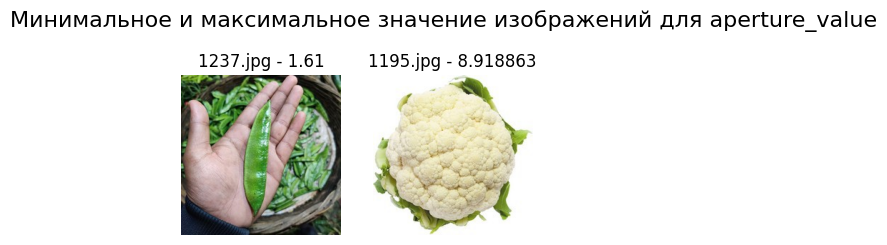

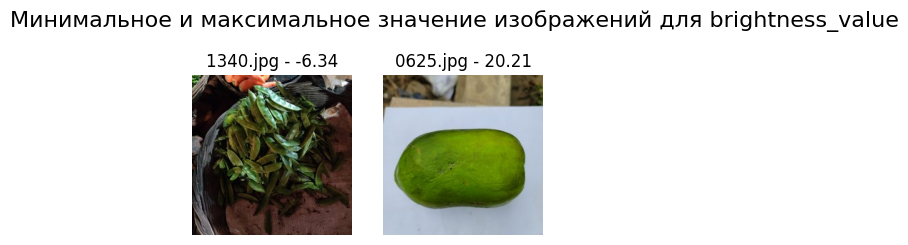

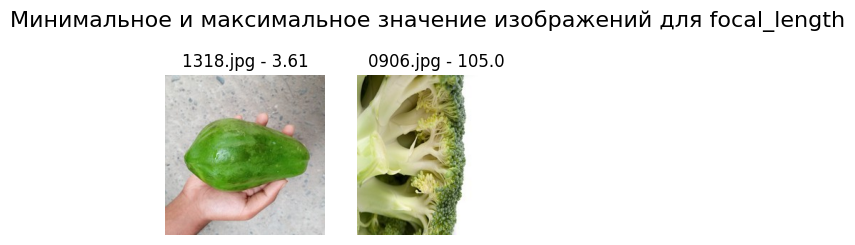

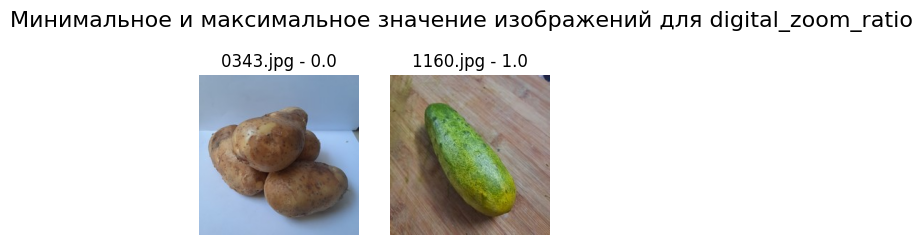

In [ ]:
show_min_max(exif_df, ["aperture_value", "brightness_value", "focal_length", "digital_zoom_ratio"])

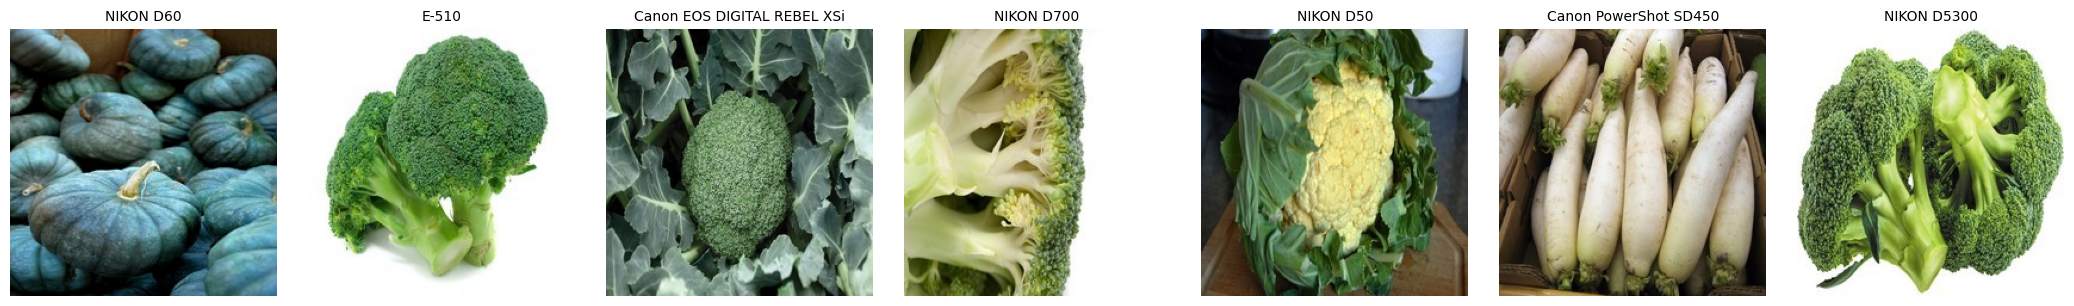

In [ ]:
models = random.sample(list(exif_df["model"].dropna().unique()), 7)
fig, axes = plt.subplots(1, 7, figsize=(21, 3))

for i, model in enumerate(models):
    row = exif_df[exif_df["model"] == model].iloc[0]
    img_class_path = os.path.join(DATASET_DIR, row["class"])
    img_path = os.path.join(img_class_path, row["name"])
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(model, fontsize=10)
plt.tight_layout()
plt.show()

Визуально заметно, что изображения с различным фокусным расстоянием и яркостью отличаются друг от друга по этим признакам.  
Также качество изображений отличается в зависимости от модели камеры.

*Метаданные могут пригодиться в дальнейшей работе*

## 3. Изучение связи изображений с целевой переменной

Визуально проанализируем несколько примеров изображений из каждого класса, чтобы лучше понять взаимосвязь между изображением и целевой переменной

In [ ]:
# Функция для отображения нескольких изображений из классов
def show_images(folder_path, cl, num_images=5):
    image_files = random.sample(os.listdir(folder_path), num_images)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(image_files):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(cl)
        plt.axis("off")
    plt.show()

In [ ]:
for cl in classes:
    folder_path = os.path.join(DATASET_DIR, cl)
    show_images(folder_path, cl)

Для класса **Tomato**:  
Большая часть изображений в данном классе растянуты и сплюснуты.

Для класса **Radish**:  
Редис на изображениях светлый и вытянутый. Так же бывает круглый и красный редис, но в датасете такие не представлены

Для класса **Brinjal**:  
Все баклажаны в датасете зеленого цвета. Баклажаны чаще встречаются фиолетового цвета, в датасете не представлены.

Для класса **Pumpkin**:  
Тыквы в датасете все одинакового цвета, больше похожи на арбуз. Тыквы часто бывают рыжего цвета, но в датасете не представлены

**Небольшие изображения (100*100px)** при увеличении имеют низкое качество. В будущем это может плохо сказаться на обучении модели, так как такие изображения содержат маленькую детализацию и объект на них тяжелее классифицировать.

Присутствуют изображения с измененной контрастностью и резкозтью.  
Также присутствуют изображения повернутые на угол. У таких изображений в углах с отсутствием изображения залит белый цвет.

## 4. Визуализация данных

### Проверка изображений на дубликаты

В одной папке (классе) могут содержаться дублирующиеся изображения. Проверим классы на дубликаты, сравнив хеш изображений:

In [ ]:
def get_hash(file_path):
    with open(file_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()


def find_duplicates(folder_path):
    hashes = {}
    duplicates = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        hash = get_hash(file_path)

        if hash in hashes:
            duplicates.append((file_path, hashes[hash]))
        else:
            hashes[hash] = file_path
    return duplicates

In [ ]:
duplicates = dict()
for cls in tqdm(classes):
    path = os.path.join(DATASET_DIR, cls)
    dup = find_duplicates(path)
    duplicates[cls] = dup

  0%|          | 0/33 [00:00<?, ?it/s]

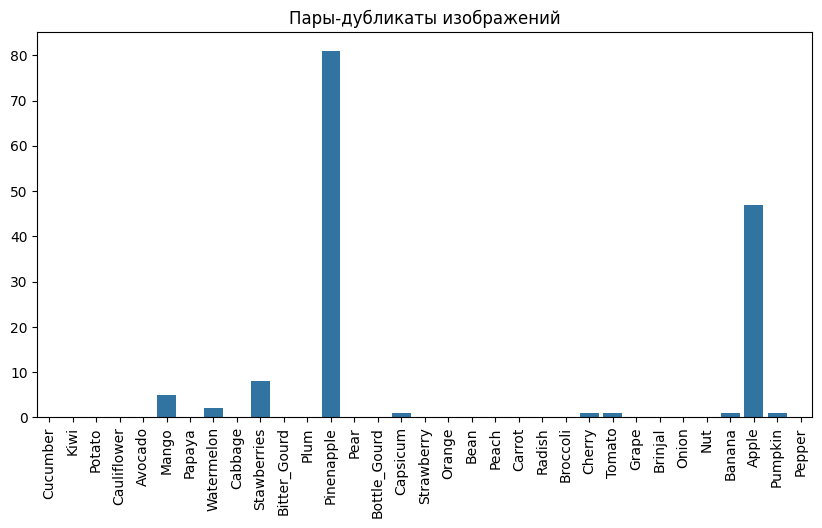

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(duplicates.keys()), y=list([len(values) for values in duplicates.values()]))
plt.xticks(rotation=90)
plt.title("Пары-дубликаты изображений")
plt.show()

**В некоторых классах встречаются дубликаты**. Достаточно моного изображений дублируется в Pinenapple (80шт) и Apple (50шт). Также встречаются дубликаты в классах Mango, Tomato, Cherry, Strawberries, Pumpkin, Watermelon, Banana, Capsicum. Следует удалить одно из дублирующихся изображений. Затем следует дополнить каждый класс до 1400 изображений методом oversampling: изменением углов изображения, яркости, контрастности, отзеркаливания и т.д.

### Распределение классов

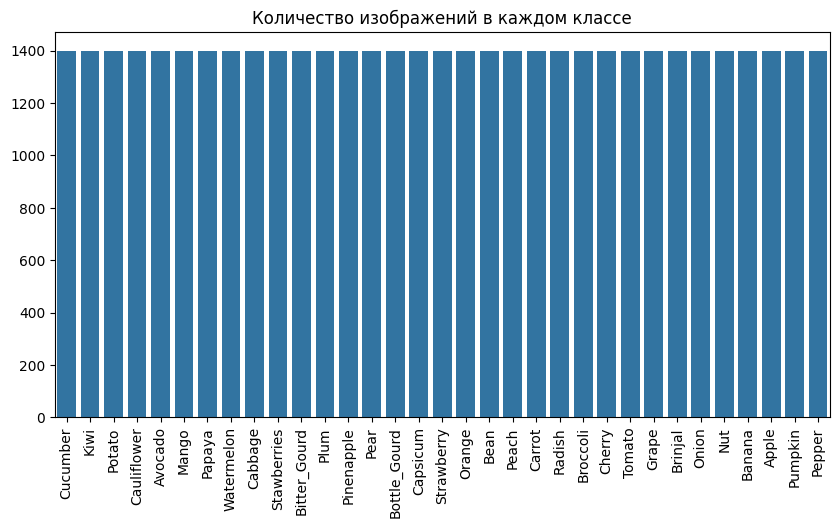

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Количество изображений в каждом классе")
plt.show()

Для каждого класса представлено 1400 изображений. Датасет хорошо сбалансирован.  
**Клубника представлена в двух классах: Strawberry и Strawberries.** Следует объеденить данные классы в один путем удаления части изображений из Strawberry и добавления части изображений из Strawberries в Strawberry (60% Strawberries и 40% Strawberry, к примеру), затем класс Strawberries удалить.

## 5. Первичная предобработка изображений

### Удаление дубликатов изображений

Дубликаты изображений могут ухудшить качество модели при обучении, поэтому их стоит заменить. Можно воспользоваться аугментациями и изменить дубликаты изображений

In [ ]:
def rotate_img(img, angle) -> Image:
    img_rotated = img.rotate(angle, fillcolor=(255, 255, 255))
    return img_rotated


def brightness_img(img, brightness_coeff) -> Image:
    enhancer = ImageEnhance.Brightness(img)
    img_brightened = enhancer.enhance(brightness_coeff)
    return img_brightened.convert("RGB")


def contrasted_img(img, contrast_coeff) -> Image:
    enhancer = ImageEnhance.Contrast(img)
    img_contrasted = enhancer.enhance(contrast_coeff)
    return img_contrasted.convert("RGB")


def transpose_img(img) -> Image:
    img_transposed = img.transpose(Image.FLIP_LEFT_RIGHT)
    return img_transposed

In [ ]:
for cls in duplicates:
    for img_paths in duplicates[cls]:
        dup = img_paths[1]
        img = Image.open(dup)
        if img.mode != "RGB":
            img = img.convert("RGB")

        img = transpose_img(img)

        br = round(random.uniform(0.5, 1.5), 2)
        while br == 1:
            br = round(random.uniform(0.5, 1.5), 2)
        img = brightness_img(img, br)

        deg = random.randint(1, 359)
        img = rotate_img(img, deg)

        contr = round(random.uniform(0.5, 1.5), 2)
        while contr == 1:
            contr = round(random.uniform(0.5, 1.5), 2)
        img = contrasted_img(img, contr)

        img.save(dup)

In [ ]:
duplicates = dict()
for cls in tqdm(classes):
    path = os.path.join(DATASET_DIR, cls)
    dup = find_duplicates(path)
    duplicates[cls] = dup

  0%|          | 0/33 [00:00<?, ?it/s]

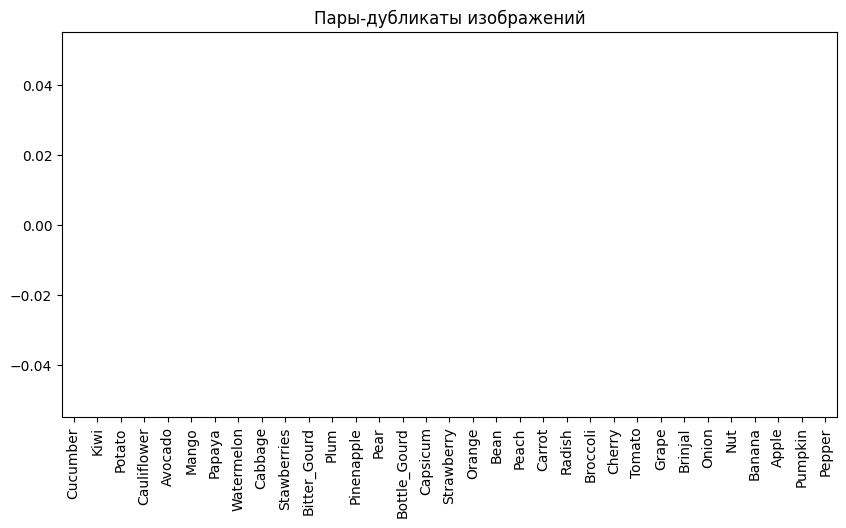

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(duplicates.keys()), y=list([len(values) for values in duplicates.values()]))
plt.xticks(rotation=90)
plt.title("Пары-дубликаты изображений")
plt.show()

Дубликатов не осталось

### Объединение дублирующихся классов

Дублирующиеся классы Strawberries и Strawberry стоит объединить, оставив 1400 изображений.  
В классе Strawberries собраны более разнообразные изображения, в Strawberry находятся изображения ягоды под разными углами. Добавим к 40% изображениям из Strawberry 60% изображений Strawberries, получив класс из 1400 изображений с названием Strawberry.

In [ ]:
class_to_move = os.path.join(DATASET_DIR, "Strawberry")
class_to_remove = os.path.join(DATASET_DIR, "Stawberries")

# Удалить 40% из Strawberry
strawberry_files = os.listdir(class_to_move)
files_to_remove = random.sample(strawberry_files, int(1400 * 0.6))
for f in files_to_remove:
    rm_path = os.path.join(class_to_move, f)
    if os.path.exists(rm_path):
        os.remove(rm_path)

# Переместить 60% из Strawberries в Strawberry
strawberries_files = os.listdir(class_to_remove)
files_to_move = random.sample(strawberries_files, int(1400 * (1 - 0.4)))
for f in files_to_move:
    mv_path = os.path.join(class_to_remove, f)
    if os.path.exists(mv_path):
        shutil.move(mv_path, class_to_move)

# Удалить оставшийся дублирующийся класс
shutil.rmtree(class_to_remove)

In [ ]:
classes = os.listdir(DATASET_DIR)
class_counts = {cl: len(os.listdir(os.path.join(DATASET_DIR, cl))) for cl in classes}

Проверим классы

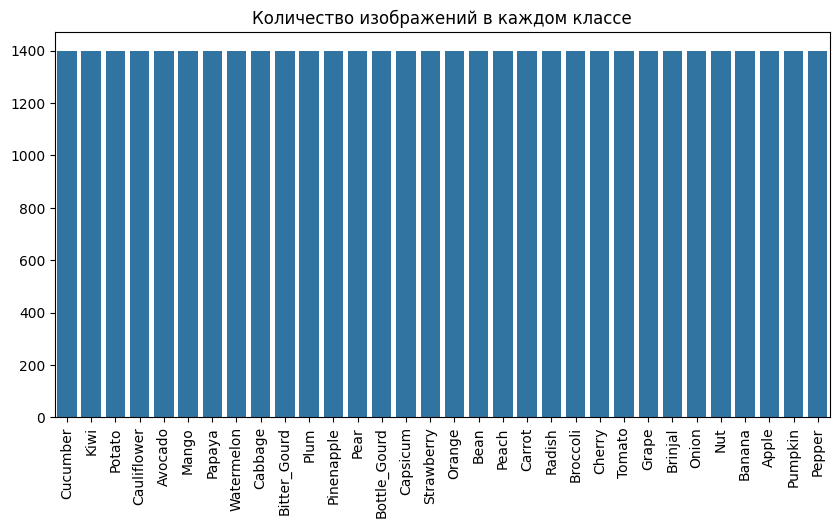

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Количество изображений в каждом классе")
plt.show()

Осталось 32 класса, дублирующийся класс убран. Датасет остался сбалансированным

In [ ]:
# Соберу строки с инофрмацией о размерах, пройдясь по папкам классов
row_list = []
for cl in tqdm(classes):
    folder_path = os.path.join(DATASET_DIR, cl)
    row_list.extend(check_image_sizes(folder_path, cl))

df = pd.DataFrame(row_list, columns=["class", "name", "width", "height"])

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
zip_path = os.path.join(DRIVE_DIR, "dataset_32_classes")
shutil.make_archive(zip_path, "zip", DATASET_DIR)

print("Архив создан:", zip_path + ".zip")

Архив создан: /content/drive/MyDrive/dataset_32_classes.zip


### Определение размера для ресайза или нарезки изображений

Т.к. есть изображения нестандартного размера, то можно привести их к одному размеру. Ранее было принято решение использовать оптимальный размер 224*224px. В дальнейшей работе стоит провести эксперименты по подбору оптимального размера изображений, поэтому пока что изображения останутся изначального размера. Ресайз приведен для примера.

In [ ]:
# DataFrame с информацией о картинках с нестандартным размером
incorrect_sized = df.loc[(df["width"] != 224) | (df["height"] != 224)]
incorrect_sized.head()

,class,name,width,height
0,Cucumber,115_245_100.jpg,100,100
7,Cucumber,48_r_210_100.jpg,100,100
9,Cucumber,143_r0_151_100.jpg,100,100
11,Cucumber,115_186_100.jpg,100,100
13,Cucumber,115_r_187_100.jpg,100,100


In [ ]:
def set_image_size(img_path: str, size: tuple[int, int]):
    img = Image.open(img_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    ratio = img.width / img.height
    # Широкое изображение
    if ratio > 1:
        new_width = size[0]
        new_height = int(size[0] / ratio)
    # Высокое изображение
    else:
        new_height = size[1]
        new_width = int(size[1] * ratio)
    img_resized = img.resize((new_width, new_height), Image.LANCZOS)
    img_padded = ImageOps.pad(img_resized, size, color="white", centering=(0.5, 0.5))
    img_padded.save(img_path)

In [ ]:
incorrect_sized = df[df["width"] != 224]

for row in tqdm(incorrect_sized.values):
    path = os.path.join(DATASET_DIR, row[0], row[1])
    set_image_size(path, (224, 224))

  0%|          | 0/26525 [00:00<?, ?it/s]

In [ ]:
row_list = []
for cl in tqdm(classes):
    folder_path = os.path.join(DATASET_DIR, cl)
    row_list.extend(check_image_sizes(folder_path, cl))

print(row_list[0])

  0%|          | 0/32 [00:00<?, ?it/s]

['Cucumber', '115_245_100.jpg', 224, 224]


In [ ]:
df = pd.DataFrame(row_list, columns=["class", "name", "width", "height"])
df.describe()

,width,height
count,44800.0,44800.000000
mean,224.0,223.997299
std,0.0,0.315124
min,224.0,187.000000
25%,224.0,224.000000
50%,224.0,224.000000
75%,224.0,224.000000
max,224.0,225.000000


In [ ]:
for cl in classes:
    folder_path = os.path.join(DATASET_DIR, cl)
    show_images(folder_path, cl)

Датасет получилось привести к единому размеру изображений 224*224px